In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and merge data
file_path = "./static_data_summary.csv"
data = pd.read_csv(file_path)

downtown_file_path = "./Downtown_Tracts.csv"
downtown_data = pd.read_csv(downtown_file_path)
downtown_data['is_downtown'] = 0

data = pd.merge(data, downtown_data[['TractID', 'is_downtown']], left_on='geoid10', right_on='TractID', how='left')
data['is_downtown'].fillna(1, inplace=True)
data['is_downtown'] = data['is_downtown'].astype(int)

ridesourcing_file_path = "./Ridesourcing_CensusCount_ALL_0_Filled.csv"
ridesourcing_data = pd.read_csv(ridesourcing_file_path)
ridesourcing_data['tract_id'] = ridesourcing_data['index']
ridesourcing_data = ridesourcing_data.drop(columns=['index'])
ridesourcing_data['total_travel_demand'] = ridesourcing_data.sum(axis=1)

data = pd.merge(data, ridesourcing_data[['tract_id', 'total_travel_demand']], left_on='geoid10', right_on='tract_id', how='left')

# Apply log transformation to target variable
data['log_total_travel_demand'] = np.log1p(data['total_travel_demand'])

# Ensures that all downtown tracts come before non-downtown tracts (or vice versa)
data = data.sort_values(by=['is_downtown', 'geoid10'])

# Extract features and labels
features = data.drop(columns=['geoid10', 'total_travel_demand', 'tract_id', 'TractID', 'log_total_travel_demand'])
labels = data['log_total_travel_demand']

# Normalize features using Min-Max Scaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Feedforward neural network with 3 hidden layers (64 neurons each) and ReLU activations.
class MonotonicNN(nn.Module):
    def __init__(self, input_dim):
        super(MonotonicNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Loss function with monotonicity penalty
def monotonicity_penalty(preds, monotonic_indices, weight=1.0):
    penalty = 0.0
    for idx in monotonic_indices:
        if preds[idx] < preds[idx - 1]:
            penalty += (preds[idx - 1] - preds[idx]) ** 2
    return weight * penalty

# Total Loss Function = (mse_loss) + lam(monotonicity_penalty)
def total_loss_function(preds, targets, monotonic_indices, penalty_weight=1.0):
    mse_loss = nn.MSELoss()(preds, targets)
    penalty = monotonicity_penalty(preds, monotonic_indices, weight=penalty_weight)
    total_loss = mse_loss + penalty
    return total_loss, mse_loss, penalty

# Define a function to train and evaluate the model with a given penalty weight
def train_and_evaluate_model(penalty_weight, x_train, y_train, x_test, y_test, input_dim, epochs=100):
    model = MonotonicNN(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
    
    training_losses = []
    mse_losses = []
    penalty_losses = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(x_train)
        
        monotonic_indices = range(1, len(preds))
        loss, mse_loss, penalty = total_loss_function(preds, y_train, monotonic_indices, penalty_weight=penalty_weight)
        
        loss.backward()
        optimizer.step()
        
        training_losses.append(loss.item())
        mse_losses.append(mse_loss.item())
        penalty_losses.append(penalty.item())
    
    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        test_preds = model(x_test)
        test_mse_loss = nn.MSELoss()(test_preds, y_test).item()
    
    return training_losses, mse_losses, penalty_losses, test_mse_loss, model

# Define penalty weights to test
penalty_weights = [0.0, 0.1, 0.5, 1.0]

# Store results for each penalty weight
results = {}

input_dim = X_train.shape[1]  # Number of input features

for weight in penalty_weights:
    training_losses, mse_losses, penalty_losses, test_mse_loss, model = train_and_evaluate_model(weight, X_train, y_train, X_test, y_test, input_dim)
    results[weight] = {
        "training_losses": training_losses,
        "mse_losses": mse_losses,
        "penalty_losses": penalty_losses,
        "test_mse_loss": test_mse_loss,
        "model": model
    }

# Print predictive accuracy results
for weight in penalty_weights:
    print(f"Lambda = {weight}: Test MSE = {results[weight]['test_mse_loss']:.4f}")

Lambda = 0.0: Test MSE = 1.0144
Lambda = 0.1: Test MSE = 0.0138
Lambda = 0.5: Test MSE = 0.0018
Lambda = 1.0: Test MSE = 0.0001


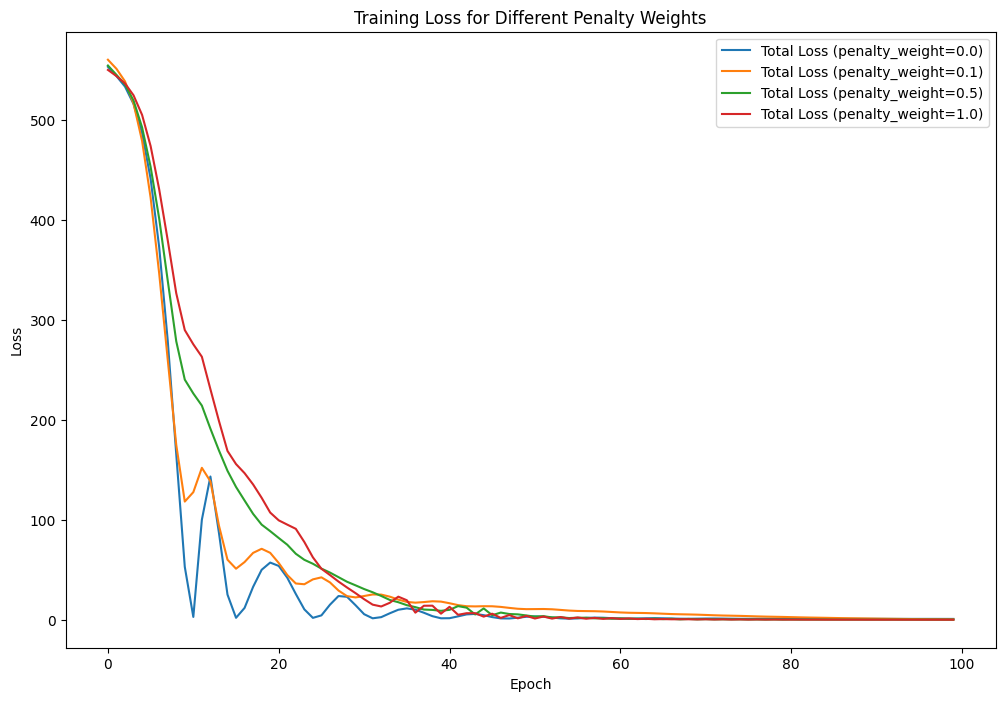

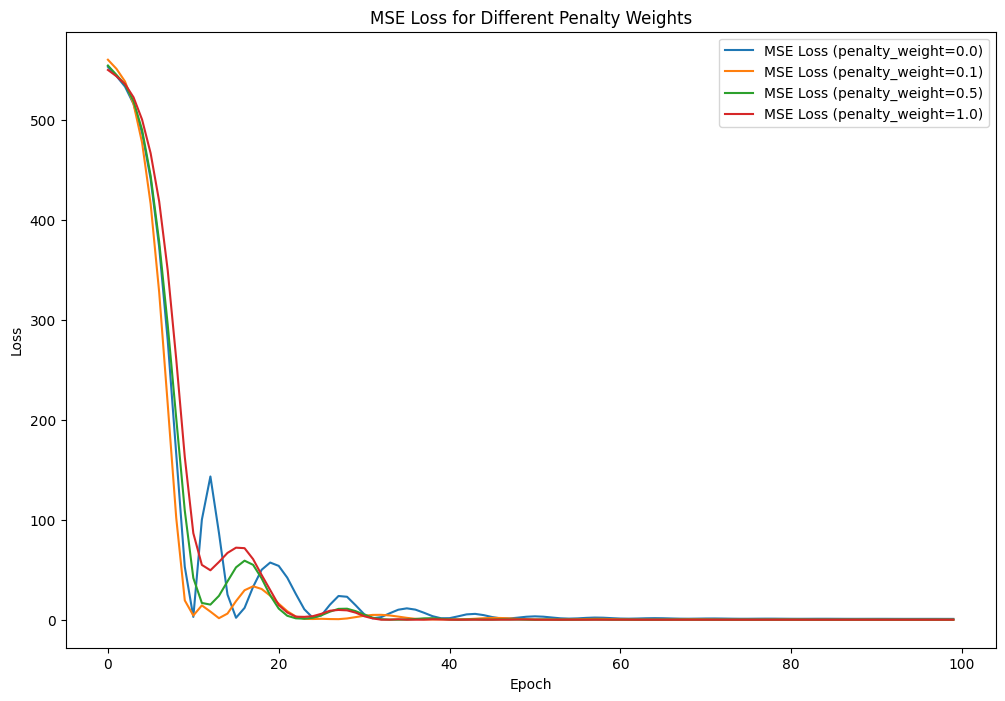

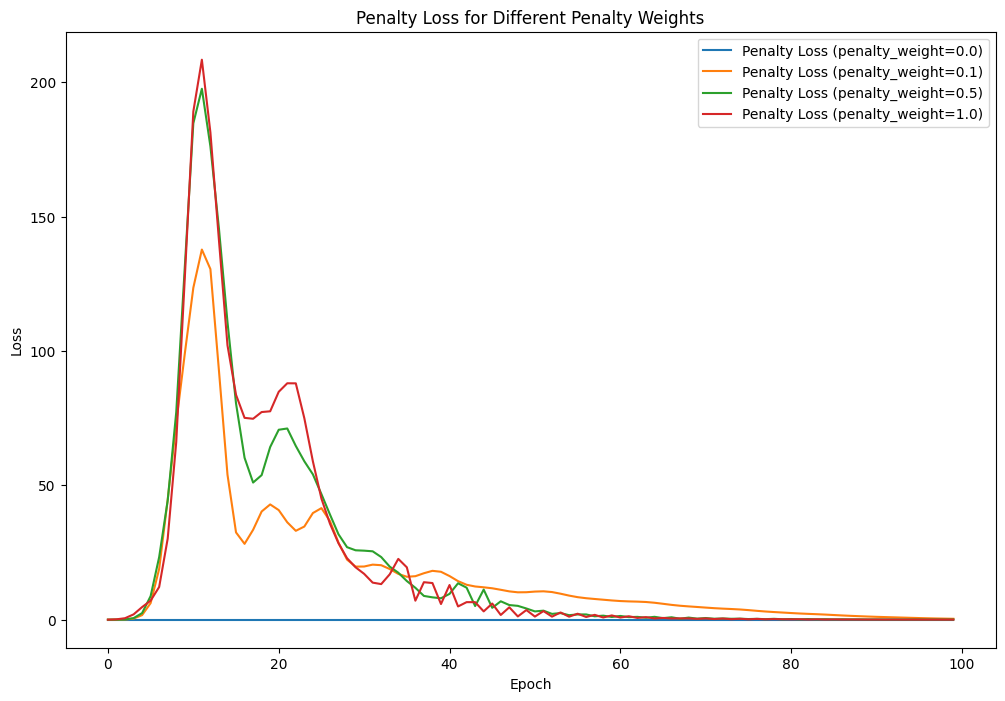

In [7]:
# Visualize the results
plt.figure(figsize=(12, 8))
for weight in penalty_weights:
    plt.plot(results[weight]['training_losses'], label=f'Total Loss (penalty_weight={weight})')
plt.title('Training Loss for Different Penalty Weights')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for weight in penalty_weights:
    plt.plot(results[weight]['mse_losses'], label=f'MSE Loss (penalty_weight={weight})')
plt.title('MSE Loss for Different Penalty Weights')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for weight in penalty_weights:
    penalty_losses_np = results[weight]['penalty_losses']
    plt.plot(penalty_losses_np, label=f'Penalty Loss (penalty_weight={weight})')
plt.title('Penalty Loss for Different Penalty Weights')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()